## Init Cell

In [1]:
! pip install -q pandas numpy tensorboard catboost scipy matplotlib scikit-learn xgboost nltk colorlog pathlib spacy seaborn optuna mlflow ipywidgets
! spacy download en_core_web_sm
! spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 27.6 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 25.6 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


In [3]:
from src.logger import setup_logger, ROOT_DIR # логирование и корневая папка

# Параметры и конфиги для обучения/экпериментов
from src.ml_utils.config import (
    PreprocessParams,
    TrainingParams,
    Classifier
)

# Утилиты, чтобы не захломлять блокнот
# Все исходники лежат в папке src/ml_utils
from src.ml_utils.utils import (
    filter_n_most_common_categories,
    get_feature_pipeline,
    train_step
)

import warnings  # предупреждения в питухоне
import logging   # логирование базовое
import time  # замеры времени
import json
import gc  # очистка мусора
import os  # для создания папки с сейв-чекпоинтами
from dataclasses import asdict  # перевод датаклассов в словари (будь они прокляты!)
from typing import Dict  # типизация всему голова

# Отрубаем ошибки, потому что мы нефоры (чтобы не захломлять блокнот)
warnings.filterwarnings("ignore", category=UserWarning)
def warn(*args, **kwargs):
    pass
warnings.warn = warn

import pandas as pd  # работа с табличными данными
import joblib  # сохранение моделек и пайплайнов

# Магические методы из sklearn, которые спасают время
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Кастомные бустинги
from catboost import CatBoostClassifier  # от наших слонов
from xgboost import XGBClassifier  # и наших рисных коллег

from src.ml_utils.transformers import TextCleaner, SpacyTokenizer, TokenProcessor

setup_logger(
    level=logging.INFO,
    stdout_log=True,
    file_log=False
)
logging.info('Modules loaded successfully!')

>>> [2025-02-04 | 05:12:24] logger:70 - WARNING - Log file wasn't created due to file_log=False
>>> [2025-02-04 | 05:12:24] 4073674517:57 - INFO - Modules loaded successfully!


## Data loading & Cleaning

In [7]:
df_data = pd.read_json("data/reuters_articles_total.json") # загружаем данные из json
df_data.info() # информация о таблице
df_data.sample(3)  # выборка 3-х случайных строк

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3942 entries, 0 to 3941
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article_id  3942 non-null   object
 1   title       3942 non-null   object
 2   category    3942 non-null   object
 3   tags        3942 non-null   object
 4   text        3942 non-null   object
dtypes: object(5)
memory usage: 154.1+ KB


,article_id,title,category,tags,text
2685,https://www.reuters.com/technology/chinas-wuxi...,China's WuXi to sell Advanced Therapies unit a...,technology,"[RHPI:MERGERS-ACQUISITIONS, BACT, BIODRG, BIZ,...",Dec 24 (Reuters) - China's WuXi AppTec (603259...
3090,https://www.reuters.com/business/energy/trumps...,"Trump's tariffs to have limited impact on oil,...",markets,"[REPI:OPEC, REPI:STORAGE, REPI:GAS, MTPIX, BIS...",Feb 3 (Reuters) - The new tariffs imposed by U...
4,https://www.reuters.com/world/americas/premier...,Premier of Canada's most populous province see...,world,"[TOPIC:WORLD-CANADA, AUT, AUTO, CDM, CYCS, CYC...","OTTAWA, Jan 24 (Reuters) - The premier of Onta..."


## Utils fuctions

In [8]:
def create_text_pipeline(params: PreprocessParams):
    return Pipeline([
        ('cleaner', TextCleaner(params)),
        ('tokenizer', SpacyTokenizer(params)),
        ('processor', TokenProcessor(params)),
        ('vectorizer', TfidfVectorizer())
    ], verbose=params.verbose)

def get_feature_pipeline(params: PreprocessParams):
    text_columns = ['text', 'title']
    text_transformers = [
        (f'{col}_pipeline', create_text_pipeline(params), col)
        for col in text_columns
    ]

    transformer = ColumnTransformer(
        transformers=[
            *text_transformers,
            ('tags_preprocess', OneHotEncoder(sparse_output=False, drop='first'), ['tags']),
        ],
        remainder='drop',
        verbose=params.verbose,
        sparse_threshold=1,
    )

    pipe = Pipeline(steps=[('column_processor', transformer)], verbose=params.verbose)

    return pipe

def split_data_step(_df: pd.DataFrame, _preprocess_params: PreprocessParams,  _train_params: TrainingParams):
        """
        Функция подготовки данных

        Шаги функции:
        1) Кодирует категориальный target
        2) Обрабатывает features через Pipeline для преобработки.
           Pipeline состоит из последовательной обработки столбцов через ColumnTransformer:
              * Колонку tags кодирует через OneHotEncoder
              * Колонки title и text обрабатывает NLP Pipeline'ом: Очистка текста, лемматизация/стемминг, токенизация, векторизация
        3) Разделяет данные на тренировочную и тестовую выборки

        param: _df (pd.DataFrame): Исходная таблица с сырыми данными
        param: _preprocess_params (PreprocessParams): Параметры для препроцессинга
        param: _train_params (TrainingParams): Параметры для тренировки (по факту нужен для train_test_split)

        Returns: X_train, X_test, y_train, y_test, pipeline_features, TargetEncoder
        """
        logging.info('Split data step has been started')
        le = LabelEncoder() # создаём кодировщик и применяем его к target
        _df['category'] = le.fit_transform(_df['category'].astype(str))

        # Разбиваем данные на features и target
        X = _df.drop(['category'], axis=1)
        y = _df.pop('category')

        # Прогоняем pipeline для features
        pipe_feature = get_feature_pipeline(_preprocess_params)
        display(pipe_feature)
        X_transformed = pipe_feature.fit_transform(X)

        try:
            os.makedirs(ROOT_DIR / 'vectorized_data', exist_ok=True)
            joblib.dump(X_transformed, ROOT_DIR / 'vectorized_data/X.pkl')
            joblib.dump(y, ROOT_DIR / 'vectorized_data/y.pkl')
            logging.info(f'Vectorized data was saved at: {ROOT_DIR / "vectorized_data"}')
        except Exception as e:
            logging.error(e, exc_info=True)


        # Разбиваем на тренировочный и тестовый сабсет
        _X_train, _X_test, _y_train, _y_test = train_test_split(
                X_transformed.toarray(),
                y,
                test_size=_train_params.test_size,
                random_state=_train_params.random_state,
                shuffle=_train_params.shuffle_split
        )

        return _X_train, _X_test, _y_train, _y_test, pipe_feature, le

def evaluation_step(_X_test, _y_test, clf: Classifier) -> Dict:
    """Функция вывода классификационных метрик для оценки модели"""
    logging.info(f'Evaluation step has been started for {clf.name}')
    # Получаем предсказания
    y_pred = clf.estim.predict(_X_test)
    # Ставим читабельный формат для pandas таблиц
    pd.options.display.float_format = '{:,.2f}'.format
    # Вывод таблицы базовых метрик
    metrics_dict = classification_report(y_true=_y_test, y_pred=y_pred, zero_division=0, output_dict=True)
    display(pd.DataFrame(metrics_dict))
    # Вывод матрицы потерь
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(_y_test, y_pred)).plot()
    return metrics_dict

def save_step(clf: Classifier, _preprocess_params: PreprocessParams, _train_params: TrainingParams,
                    x_pipeline: Pipeline, y_estim: BaseEstimator, m_dict: Dict) -> None:
     """Функция сохранения всего для воспроизведения"""
     logging.info('Save step has been started')
     save_dir = ROOT_DIR / f'pretrained/{clf.name}'
     os.makedirs(save_dir, exist_ok=True)
     joblib.dump(clf.estim, save_dir / "model.pkl")
     joblib.dump(x_pipeline, save_dir / 'x_pipe.pkl')
     joblib.dump(y_estim, save_dir / 'y_estim.pkl')

     with open(save_dir / 'preprocess_params.json', 'w') as json_file:
        json.dump(asdict(_preprocess_params), json_file, indent=4)

     with open(save_dir / 'train_params.json', 'w') as json_file:
        json.dump(asdict(_train_params), json_file, indent=4)

     with open(save_dir / 'metrics_eval.json', 'w') as json_file:
        json.dump(m_dict, json_file, indent=4)

     logging.info(f'Save checkpoint was created successully at: {save_dir}')

def experement_step(clf: Classifier, _preprocess_params: PreprocessParams, _train_params: TrainingParams, *args) -> None:
    """
    Функция эксперементов, принимает классификатор, все сабсеты данных и параметры тренировки.
    Выдаёт инфу про обучение и оценку. Заодно и сохраняет всё добро
    """
    logging.info('Experiment step has been started')
    logging.info(f"Garbage collected: {gc.collect()}")
    _X_train, _X_test, _y_train, _y_test, x_estim, y_estim = args
    start_time = time.time()
    trained_clf = train_step(_X_train, _y_train,
           clf=clf,
           train_params=_train_params
    )
    logging.info(f"Train step time: {time.time() - start_time:.2f}")
    m_dict = evaluation_step(_X_test, _y_test, trained_clf)
    save_step(clf, _preprocess_params, _train_params, x_estim, y_estim, m_dict)

## Params Cell

In [65]:
# Параметры, ключи в датаклассе сами говорят, за что они отвечают :)
preprocess_params = PreprocessParams(
        spacy_model="en_core_web_sm",
        remove_punct=True,
        custom_punct=r'[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]',
        remove_stopwords=True,
        lemmatize=True,
        stem=False,
        lowercase=True,
        min_token_length=2,
        verbose=True
)

train_params = TrainingParams(
        test_size=0.2,
        random_state=42,
        shuffle_split=True,
        n_jobs=1
)

In [66]:
classifiers = [
    Classifier(
        name='CatBoostClassifier',
        estim=CatBoostClassifier(task_type="GPU", devices='0', random_state=train_params.random_state, verbose=False),
        tuning_params=False
    ),
    Classifier(
        name='XGBClassifier',
        estim=XGBClassifier(tree_method="hist", device="cuda", random_state=train_params.random_state),
        tuning_params=False
    ),
    Classifier(
        name='RidgeClassifier',
        estim=RidgeClassifier(random_state=train_params.random_state),
        param_grid={
            'alpha': [0.01, 0.1, 0.5, 1.0, 10.0, 100.0],
            'fit_intercept': [True, False],
            'class_weight': [None, 'balanced'],
            'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
        },
        tuning_params=True
    ),
    Classifier(
        name='RandomForestClassifier',
        estim=RandomForestClassifier(random_state=train_params.random_state),
        param_grid = {
            'n_estimators': [50, 100, 200, 300],
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 10, 20, 30, 40],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2'],
            'bootstrap': [True, False],
            'class_weight': [None, 'balanced', 'balanced_subsample'],
            'oob_score': [True, False]
        },
        tuning_params=True
    ),
    Classifier(
        name='GradientBoostingClassifier',
        estim=GradientBoostingClassifier(random_state=train_params.random_state),
        param_grid = {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2, 0.3],
            'max_depth': [3, 4, 5, 6],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'subsample': [0.8, 0.9, 1.0],
            'max_features': ['auto', 'sqrt', 'log2'],
            'criterion': ['friedman_mse', 'mse', 'mae']
        },
        tuning_params=True
    ),
    Classifier(
        name='MLPClassifier',
        estim=MLPClassifier(random_state=train_params.random_state),
        param_grid = {
            'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
            'activation': ['logistic', 'tanh', 'relu'],
            'solver': ['lbfgs', 'sgd', 'adam'],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate': ['constant', 'invscaling', 'adaptive'],
            'learning_rate_init': [0.001, 0.01, 0.1],
            'max_iter': [200, 500, 1000],
            'batch_size': ['auto', 32, 64, 128],
            'early_stopping': [True, False],
            'validation_fraction': [0.1, 0.2],
            'tol': [1e-4, 1e-3],
            'momentum': [0.9, 0.95, 0.99]
        },
        tuning_params=True
    ),
    Classifier(
        name='KNeighborsClassifier',
        estim=KNeighborsClassifier(),
        param_grid = {
            'n_neighbors': [3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': [10, 20, 30, 50],
            'p': [1, 2],
            'metric': ['minkowski', 'euclidean', 'manhattan', 'chebyshev']
        },
        tuning_params=True
    )
]

# Main Cell

In [73]:
packed_data_from_splits = split_data_step(
    df_data.copy(deep=True),
    preprocess_params,
    train_params
)

>>> [2025-02-04 | 04:57:16] 724128593:19 - INFO - Split data step has been started
>>> [2025-02-04 | 04:57:16] wrapper:21 - INFO - Loading dictionaries from /home/kitsu/nlp_hse/.venv/lib/python3.10/site-packages/pymorphy3_dicts_ru/data
>>> [2025-02-04 | 04:57:16] wrapper:25 - INFO - format: 2.4, revision: 417150, updated: 2022-01-08T22:09:24.565962
>>> [2025-02-04 | 04:57:16] wrapper:21 - INFO - Loading dictionaries from /home/kitsu/nlp_hse/.venv/lib/python3.10/site-packages/pymorphy3_dicts_ru/data
>>> [2025-02-04 | 04:57:16] wrapper:25 - INFO - format: 2.4, revision: 417150, updated: 2022-01-08T22:09:24.565962
>>> [2025-02-04 | 04:57:17] wrapper:21 - INFO - Loading dictionaries from /home/kitsu/nlp_hse/.venv/lib/python3.10/site-packages/pymorphy3_dicts_ru/data
>>> [2025-02-04 | 04:57:17] wrapper:25 - INFO - format: 2.4, revision: 417150, updated: 2022-01-08T22:09:24.565962
>>> [2025-02-04 | 04:57:18] wrapper:21 - INFO - Loading dictionaries from /home/kitsu/nlp_hse/.venv/lib/python3.1

Pipeline(steps=[('column_processor',
                 ColumnTransformer(sparse_threshold=1,
                                   transformers=[('text_pipeline',
                                                  Pipeline(steps=[('cleaner',
                                                                   TextCleaner(params=PreprocessParams(spacy_model='ru_core_news_sm',
                                                                                                       remove_punct=True,
                                                                                                       custom_punct='[!"#$%&\\\'()*+,-./:;<=>?@[\\\\]^_`{|}~]',
                                                                                                       remove_stopwords=True,
                                                                                                       lemmatize=True,
                                                                                                       stem=False,
                                                                                                       lowercase=True,
                                                                                                       min_token_length...
                                                                   TokenProcessor(params=PreprocessParams(spacy_model='ru_core_news_sm',
                                                                                                          remove_punct=True,
                                                                                                          custom_punct='[!"#$%&\\\'()*+,-./:;<=>?@[\\\\]^_`{|}~]',
                                                                                                          remove_stopwords=True,
                                                                                                          lemmatize=True,
                                                                                                          stem=False,
                                                                                                          lowercase=True,
                                                                                                          min_token_length=2,
                                                                                                          verbose=True))),
                                                                  ('vectorizer',
                                                                   TfidfVectorizer())],
                                                           verbose=True),
                                                  'title'),
                                                 ('tags_preprocess',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['tags'])],
                                   verbose=True))],
         verbose=True)

>>> [2025-02-04 | 04:57:19] wrapper:21 - INFO - Loading dictionaries from /home/kitsu/nlp_hse/.venv/lib/python3.10/site-packages/pymorphy3_dicts_ru/data
>>> [2025-02-04 | 04:57:19] wrapper:25 - INFO - format: 2.4, revision: 417150, updated: 2022-01-08T22:09:24.565962
>>> [2025-02-04 | 04:57:19] wrapper:21 - INFO - Loading dictionaries from /home/kitsu/nlp_hse/.venv/lib/python3.10/site-packages/pymorphy3_dicts_ru/data
>>> [2025-02-04 | 04:57:19] wrapper:25 - INFO - format: 2.4, revision: 417150, updated: 2022-01-08T22:09:24.565962
>>> [2025-02-04 | 04:57:20] wrapper:21 - INFO - Loading dictionaries from /home/kitsu/nlp_hse/.venv/lib/python3.10/site-packages/pymorphy3_dicts_ru/data
>>> [2025-02-04 | 04:57:20] wrapper:25 - INFO - format: 2.4, revision: 417150, updated: 2022-01-08T22:09:24.565962
>>> [2025-02-04 | 04:57:21] wrapper:21 - INFO - Loading dictionaries from /home/kitsu/nlp_hse/.venv/lib/python3.10/site-packages/pymorphy3_dicts_ru/data
>>> [2025-02-04 | 04:57:21] wrapper:25 - IN

### CatBoostClassifier

>>> [2025-02-04 | 04:44:02] 1198373295:83 - INFO - Experiment step has been started
>>> [2025-02-04 | 04:44:03] 1198373295:84 - INFO - Garbage collected: 119476
>>> [2025-02-04 | 04:44:03] utils:109 - INFO - Fit step has started for CatBoostClassifier
>>> [2025-02-04 | 04:44:11] utils:111 - INFO - Fit step finished successfully!
>>> [2025-02-04 | 04:44:11] 1198373295:91 - INFO - Train step time: 8.18
>>> [2025-02-04 | 04:44:11] 1198373295:45 - INFO - Evaluation step has been started for CatBoostClassifier


,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.50,0.44,1.00,1.00,0.67,0.65,0.72,0.78
recall,0.50,0.80,0.17,1.00,1.00,0.65,0.69,0.65
f1-score,0.50,0.57,0.29,1.00,0.80,0.65,0.63,0.61
support,2.00,5.00,6.00,5.00,2.00,0.65,20.00,20.00


>>> [2025-02-04 | 04:44:11] 1198373295:60 - INFO - Save step has been started
>>> [2025-02-04 | 04:44:25] 1198373295:76 - INFO - Save checkpoint was created successully at: /home/kitsu/nlp_hse/pretrained/CatBoostClassifier


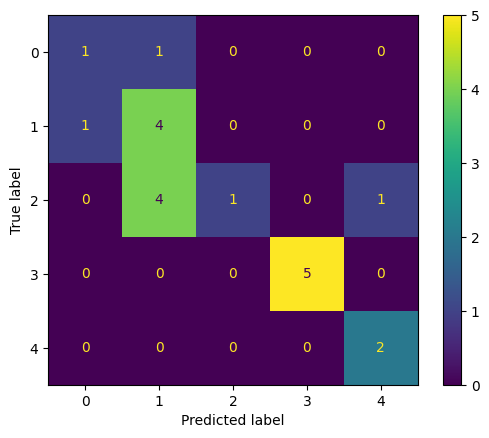

In [54]:
experement_step(classifiers[0], preprocess_params, train_params, *packed_data_from_splits)

### XGBClassifier

>>> [2025-02-04 | 04:44:40] 1198373295:83 - INFO - Experiment step has been started
>>> [2025-02-04 | 04:44:40] 1198373295:84 - INFO - Garbage collected: 6967
>>> [2025-02-04 | 04:44:40] utils:109 - INFO - Fit step has started for XGBClassifier
>>> [2025-02-04 | 04:44:41] utils:111 - INFO - Fit step finished successfully!
>>> [2025-02-04 | 04:44:41] 1198373295:91 - INFO - Train step time: 1.08
>>> [2025-02-04 | 04:44:41] 1198373295:45 - INFO - Evaluation step has been started for XGBClassifier


,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.50,0.43,1.00,1.00,0.50,0.65,0.69,0.76
recall,0.50,0.60,0.33,1.00,1.00,0.65,0.69,0.65
f1-score,0.50,0.50,0.50,1.00,0.67,0.65,0.63,0.64
support,2.00,5.00,6.00,5.00,2.00,0.65,20.00,20.00


>>> [2025-02-04 | 04:44:41] 1198373295:60 - INFO - Save step has been started
>>> [2025-02-04 | 04:44:55] 1198373295:76 - INFO - Save checkpoint was created successully at: /home/kitsu/nlp_hse/pretrained/XGBClassifier


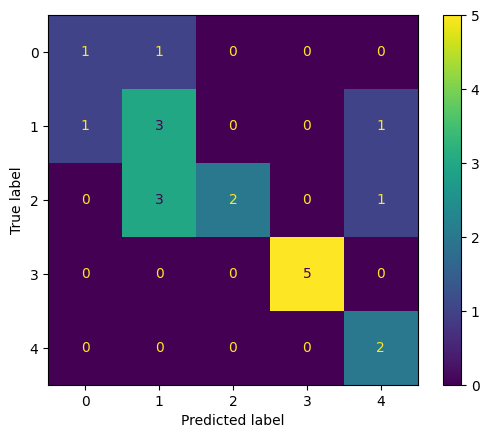

In [55]:
experement_step(classifiers[1], preprocess_params, train_params, *packed_data_from_splits)

### RidgeClassifier

>>> [2025-02-04 | 04:44:55] 1198373295:83 - INFO - Experiment step has been started
>>> [2025-02-04 | 04:44:55] 1198373295:84 - INFO - Garbage collected: 6967
>>> [2025-02-04 | 04:44:55] utils:81 - INFO - Tuning params step has started for RidgeClassifier
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 30
max_resources_: 80
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 2
n_resources: 30
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 1
n_candidates: 1
n_resources: 60
Fitting 3 folds for each of 1 candidates, totalling 3 fits
>>> [2025-02-04 | 04:44:55] utils:86 - INFO - Best Parameters for RidgeClassifier: {'solver': 'sparse_cg', 'fit_intercept': False, 'class_weight': 'balanced', 'alpha': 10.0}
>>> [2025-02-04 | 04:44:55] utils:87 - INFO - Best Estimator for RidgeClassifier: RidgeClassifier(alpha=10.0, class_weight='balanced', fit_intercept=False,
                random_state=42, solver='sparse_cg

,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,1.00,0.44,0.00,1.00,0.67,0.65,0.62,0.53
recall,1.00,0.80,0.00,1.00,1.00,0.65,0.76,0.65
f1-score,1.00,0.57,0.00,1.00,0.80,0.65,0.67,0.57
support,2.00,5.00,6.00,5.00,2.00,0.65,20.00,20.00


>>> [2025-02-04 | 04:44:55] 1198373295:60 - INFO - Save step has been started
>>> [2025-02-04 | 04:45:08] 1198373295:76 - INFO - Save checkpoint was created successully at: /home/kitsu/nlp_hse/pretrained/RidgeClassifier


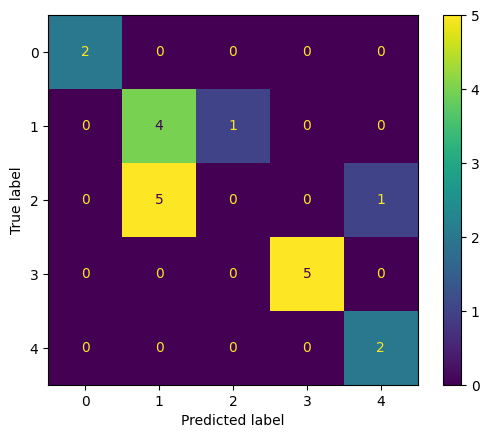

In [56]:
experement_step(classifiers[2], preprocess_params, train_params, *packed_data_from_splits)

### RandomForestClassifier

>>> [2025-02-04 | 04:45:08] 1198373295:83 - INFO - Experiment step has been started
>>> [2025-02-04 | 04:45:08] 1198373295:84 - INFO - Garbage collected: 6967
>>> [2025-02-04 | 04:45:08] utils:81 - INFO - Tuning params step has started for RandomForestClassifier
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 30
max_resources_: 80
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 2
n_resources: 30
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 1
n_candidates: 1
n_resources: 60
Fitting 3 folds for each of 1 candidates, totalling 3 fits
>>> [2025-02-04 | 04:45:10] utils:86 - INFO - Best Parameters for RandomForestClassifier: {'oob_score': True, 'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 30, 'criterion': 'gini', 'class_weight': None, 'bootstrap': True}
>>> [2025-02-04 | 04:45:10] utils:87 - INFO - Best Estimator for RandomForestClassifier: Ra

,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.00,0.25,0.00,0.00,0.00,0.25,0.05,0.06
recall,0.00,1.00,0.00,0.00,0.00,0.25,0.20,0.25
f1-score,0.00,0.40,0.00,0.00,0.00,0.25,0.08,0.10
support,2.00,5.00,6.00,5.00,2.00,0.25,20.00,20.00


>>> [2025-02-04 | 04:45:10] 1198373295:60 - INFO - Save step has been started
>>> [2025-02-04 | 04:45:25] 1198373295:76 - INFO - Save checkpoint was created successully at: /home/kitsu/nlp_hse/pretrained/RandomForestClassifier


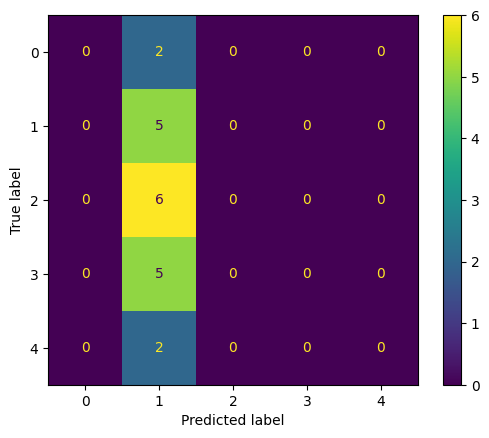

In [57]:
experement_step(classifiers[3], preprocess_params, train_params, *packed_data_from_splits)

### GradientBoostingClassifier

>>> [2025-02-04 | 04:45:25] 1198373295:83 - INFO - Experiment step has been started
>>> [2025-02-04 | 04:45:25] 1198373295:84 - INFO - Garbage collected: 7093
>>> [2025-02-04 | 04:45:25] utils:81 - INFO - Tuning params step has started for GradientBoostingClassifier
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 30
max_resources_: 80
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 2
n_resources: 30
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 1
n_candidates: 1
n_resources: 60
Fitting 3 folds for each of 1 candidates, totalling 3 fits
>>> [2025-02-04 | 04:45:27] utils:86 - INFO - Best Parameters for GradientBoostingClassifier: {'subsample': 1.0, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 6, 'learning_rate': 0.01, 'criterion': 'friedman_mse'}
>>> [2025-02-04 | 04:45:27] utils:87 - INFO - Best Estimator for GradientBoostingClassifier: Gr

,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,1.00,0.38,0.00,1.00,1.00,0.60,0.68,0.55
recall,0.50,1.00,0.00,1.00,0.50,0.60,0.60,0.60
f1-score,0.67,0.56,0.00,1.00,0.67,0.60,0.58,0.52
support,2.00,5.00,6.00,5.00,2.00,0.60,20.00,20.00


>>> [2025-02-04 | 04:45:27] 1198373295:60 - INFO - Save step has been started
>>> [2025-02-04 | 04:45:40] 1198373295:76 - INFO - Save checkpoint was created successully at: /home/kitsu/nlp_hse/pretrained/GradientBoostingClassifier


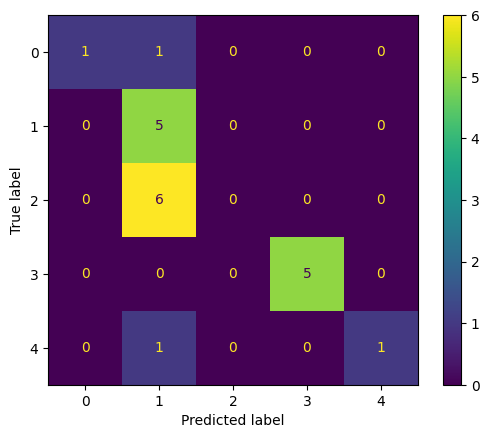

In [58]:
experement_step(classifiers[4], preprocess_params, train_params, *packed_data_from_splits)

### MLPClassifier

>>> [2025-02-04 | 04:45:40] 1198373295:83 - INFO - Experiment step has been started
>>> [2025-02-04 | 04:45:40] 1198373295:84 - INFO - Garbage collected: 7087
>>> [2025-02-04 | 04:45:40] utils:81 - INFO - Tuning params step has started for MLPClassifier
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 30
max_resources_: 80
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 2
n_resources: 30
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 1
n_candidates: 1
n_resources: 60
Fitting 3 folds for each of 1 candidates, totalling 3 fits
>>> [2025-02-04 | 04:45:48] utils:86 - INFO - Best Parameters for MLPClassifier: {'validation_fraction': 0.2, 'tol': 0.001, 'solver': 'adam', 'momentum': 0.95, 'max_iter': 1000, 'learning_rate_init': 0.001, 'learning_rate': 'constant', 'hidden_layer_sizes': (100, 50), 'early_stopping': False, 'batch_size': 64, 'alpha': 0.001, 'activation': 'tanh'}
>>> [2025-02-04 | 04:45:48] util

,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,1.00,0.44,0.50,1.00,1.00,0.70,0.79,0.71
recall,1.00,0.80,0.17,1.00,1.00,0.70,0.79,0.70
f1-score,1.00,0.57,0.25,1.00,1.00,0.70,0.76,0.67
support,2.00,5.00,6.00,5.00,2.00,0.70,20.00,20.00


>>> [2025-02-04 | 04:45:49] 1198373295:60 - INFO - Save step has been started
>>> [2025-02-04 | 04:46:02] 1198373295:76 - INFO - Save checkpoint was created successully at: /home/kitsu/nlp_hse/pretrained/MLPClassifier


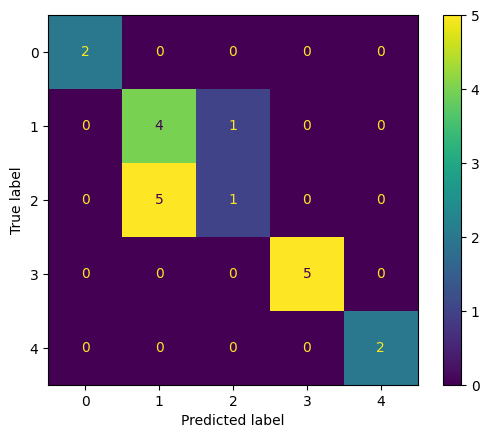

In [59]:
experement_step(classifiers[5], preprocess_params, train_params, *packed_data_from_splits)

### KNeighborsClassifier

>>> [2025-02-04 | 04:46:02] 1198373295:83 - INFO - Experiment step has been started
>>> [2025-02-04 | 04:46:02] 1198373295:84 - INFO - Garbage collected: 6967
>>> [2025-02-04 | 04:46:02] utils:81 - INFO - Tuning params step has started for KNeighborsClassifier
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 30
max_resources_: 80
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 2
n_resources: 30
Fitting 3 folds for each of 2 candidates, totalling 6 fits
----------
iter: 1
n_candidates: 1
n_resources: 60
Fitting 3 folds for each of 1 candidates, totalling 3 fits
>>> [2025-02-04 | 04:46:02] utils:86 - INFO - Best Parameters for KNeighborsClassifier: {'weights': 'uniform', 'p': 2, 'n_neighbors': 5, 'metric': 'minkowski', 'leaf_size': 30, 'algorithm': 'brute'}
>>> [2025-02-04 | 04:46:02] utils:87 - INFO - Best Estimator for KNeighborsClassifier: KNeighborsClassifier(algorithm='brute')
>>> [2025-02-04 | 04:46:02] utils:109 - INFO - Fi

,0,1,2,3,4,accuracy,macro avg,weighted avg
precision,0.67,0.38,0.33,1.00,1.00,0.60,0.68,0.61
recall,1.00,0.60,0.17,1.00,0.50,0.60,0.65,0.60
f1-score,0.80,0.46,0.22,1.00,0.67,0.60,0.63,0.58
support,2.00,5.00,6.00,5.00,2.00,0.60,20.00,20.00


>>> [2025-02-04 | 04:46:02] 1198373295:60 - INFO - Save step has been started
>>> [2025-02-04 | 04:46:14] 1198373295:76 - INFO - Save checkpoint was created successully at: /home/kitsu/nlp_hse/pretrained/KNeighborsClassifier


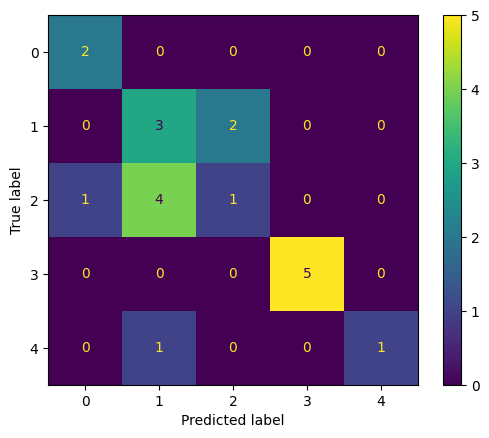

In [60]:
experement_step(classifiers[6], preprocess_params, train_params, *packed_data_from_splits)